# LangGraph

In [2]:
import ollama
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END

In [5]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]
    
    # Response generation
    email_draft: Optional[str]
    
    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

In [42]:
# Initialize our LLM
model = "llama3.2"

def read_email(state: EmailState):
    """Alfred reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """Alfred uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [UserMessage(content=prompt)]
    response = ollama.chat(model=model, messages=messages, options={"temperature": 0.0})
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.message.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.message.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """Alfred discards spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """Alfred drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [dict(role="user", content=prompt)]
    response = ollama.chat(model=model, messages=messages, options={"temperature": 0.0})
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.message.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.message.content,
        "messages": new_messages
    }

def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}


def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [43]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# Compile the graph
compiled_graph = email_graph.compile()

In [44]:
# Example legitimate email
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# Example spam email
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}
# Process the spam email
spam_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

Alfred is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
Here's a polite preliminary response:

Dear Mr. Smith,

Thank you for considering my consulting services. I appreciate the referral from your colleague and would be delighted to discuss how I can assist you.

I'd be happy to schedule a call at your convenience next week. Please let me know which day and time work best for you, and I'll make sure to adjust my schedule accordingly.

In preparation for our conversation, could you kindly provide me with some information about the specific challenges or areas of interest you'd like to explore? This will enable me to tailor our discussion and ensure we make the most of our time together.

I look forward to speaking with you soon.


In [45]:
for m in spam_result["messages"]:
    print(m)

{'role': 'user', 'content': "\n    As Alfred the butler, analyze this email and determine if it is spam or legitimate.\n\n    Email:\n    From: john.smith@example.com\n    Subject: Question about your services\n    Body: Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith\n\n    First, determine if this email is spam. If it is spam, explain why.\n    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).\n    "}
{'role': 'assistant', 'content': 'A most intriguing email, sir! As Alfred the butler, I shall analyze it with utmost care and attention to detail.\n\nUpon initial inspection, I notice that the sender\'s email address appears to be a legitimate one, as it follows the standard format of a professional email address (john.smith@example.com). The subject line is also straightforward and informative, suggesting that the email may indeed 

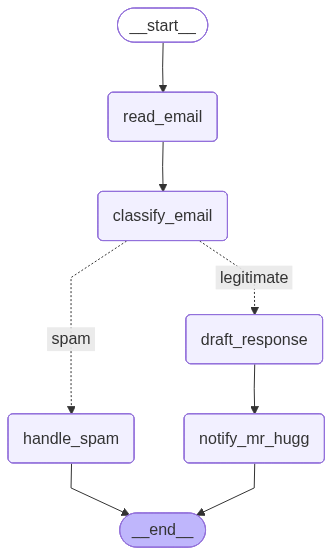

In [81]:
from IPython.display import Image, display

# View
display(Image(compiled_graph.get_graph().draw_mermaid_png()))

# Entities Extractor

### Imports

In [1]:
from pydantic import BaseModel
from typing import List, TypedDict, Annotated, Literal, Union, Dict, Any
from langgraph.graph import START, StateGraph, END, add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, AnyMessage
from langchain_ollama import ChatOllama
from IPython.display import Image, display

### Model

In [2]:
model_name = "llama3.2"
model = ChatOllama(model=model_name, temperature=0.0)

### State Graph

In [3]:
class EntitiesExtractorState(TypedDict):
    messages: Annotated[List, add_messages]

### Tools

In [4]:
ENTITIES = {
    "Driver": {
        "desc": "Person who drives a car",
        "value": None
    },
    "Location": {
        "desc": "Where the event took place",
        "value": None
    },
    "Event": {
        "desc": "Type of event",
        "value": None
    }
}

@tool
def entity_value(entity_name: str, entity_value: str) -> Dict[str, str]:
    """
    Function to indicate the value of a single entity.
    Args:
        entity_name (str): name of the entity to analyze.
        entity_value (str): Value of the entity.
    Returns:
        (Dict): Python dictionary containing the info for the entity.
    """
    return {entity_name: entity_value}

@tool
def extract_entities(text: str, entities: Dict = ENTITIES) -> Dict[str, Dict[str, str | int]]:
    """
    Performs the extraction of the entities for a given text.

    Args:
        text (str): Text to be analyzed.
        entities (Optional[Dict]): Entities to be extracted.
    
    Returns:
        (Dict[str, Dict[str, str | int]]): Python dictionary containing the entities information extracted from the text.
    """
    llm_with_tools = model.bind_tools([entity_value])
    for entity, params in entities.items():
        print(f"Analyzing entity: {entity}")
        system_prompt = f"""You have to extract an entity from a text. If the entity is not present, consider its
        value as 'None'

        Entity name: {entity}
        Entity description: {params["desc"]}
        """
        messages = [SystemMessage(content=system_prompt)] + [HumanMessage(content=text)]
        response = llm_with_tools.invoke(messages)
        params["value"] = response.tool_calls[0]["args"]["entity_value"]
    return entities

# @tool
# def provide_entities_values(driver: str, event: str, location: str, poc: str) -> Dict:
#     """
#     Indicates the entity extracted along with its corresponding value
#     Args:
#         driver (str): Driver of the racing car
#         event (str): Type of event
#         location (str): Location of the event
#     Returns:
#         (Dict[str, str]]: Python dictionary containing the entities as keys and its parameters as values
#     """
#     return {"Driver": driver, "Location": location, "Event": event, "Poc": poc}


In [5]:
from langchain_core.tools import BaseTool
from typing import Optional, Type
from pydantic import BaseModel, Field


# Step 1: Define the public schema (what the LLM sees)
class ProvideEntitiesValuesInput(BaseModel):
    driver: str = Field(description="Driver of the racing car")
    event: str = Field(description="Type of event")
    location: str = Field(description="Location of the event")


# Step 2: Define the actual tool class
class ProvideEntitiesValuesTool(BaseTool):
    name: str = "provide_entities_values"
    description: str = "Provides entity values extracted from text."
    args_schema: Type[BaseModel] = ProvideEntitiesValuesInput
    index: str = "DEFAULT"

    # You can pass internal parameters via __init__
    def __init__(self, index: str, **kwargs):
        super().__init__(**kwargs)
        self.index = index  # internal, hidden from LLM

    def _run(self, driver: str, event: str, location: str) -> dict:
        """Synchronous execution"""
        # You can call your internal function here:
        return {"Driver": driver, "Event": event, "Location": location, "Index": self.index}

    async def _arun(self, driver: str, event: str, location: str) -> dict:
        """Asynchronous execution (if needed)"""
        return self._run(driver, event, location)


In [6]:
provide_tool = ProvideEntitiesValuesTool(index="PK")

### Nodes

In [7]:
llm_with_tools = model.bind_tools([extract_entities, provide_tool])

In [8]:
def assistant(state: EntitiesExtractorState):
    prompt = """You are a helpful assistant in charge of reviewing an entities extraction process.
    Your labour is to check if there is any missing entity that could not be extracted from the text, if that is the case, just
    request those entities to the user directly. 
    **Note**: Missing entities are identified with a 'None' value.
    Do not add any entity more apart from the ones that the tools indicate.
    The steps to success would be as follows:
    1) Once you have the text to be analyzed, call 'extract_entities' tool
    2) Verify there is not any missing entity (identified with 'None' value). If there is any missing entity, request it
    to the user directly.
    3) Once you have all the entities, call 'provide_entities_values' tool to provide final result.

    Finally, since you are an assistant, maintain a chatbot mood with the user.
    """
    messages = [dict(role="system", content=prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    output = {
        "messages": response
    }
    return output

### Graph

In [9]:
def tools_condition(
    state: Union[list[AnyMessage], dict[str, Any], BaseModel],
    messages_key: str = "messages",
) -> Literal["tools", "__end__", "final_tool"]:
    
    if isinstance(state, list):
        ai_message = state[-1]
    elif isinstance(state, dict) and (messages := state.get(messages_key, [])):
        ai_message = messages[-1]
    elif messages := getattr(state, messages_key, []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        if ai_message.tool_calls[0]["name"] == "provide_entities_values":
            return "final_tool"
        else:
            return "tools"
    return "__end__"

In [11]:
# Build the graph
builder = StateGraph(EntitiesExtractorState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([extract_entities]))
builder.add_node("final_tool",ToolNode([provide_tool]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")
builder.add_edge("final_tool", END)
# builder.add_edge("assistant", END)

react_graph = builder.compile()

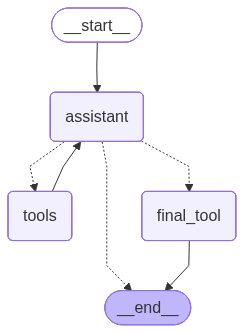

In [12]:
react_graph

### Llama3.2

In [14]:
text = "Yesterday I saw Fernando Alonso in Sevilla during the racing car"
text = "It was such an amazing experience seing Roberto Fernandez driving the new car model in Cadiz"
# text = "Hello!"
graph_res = react_graph.invoke({"messages": [HumanMessage(content=text)]})
print(graph_res["messages"][-1].content)

Analyzing entity: Driver
Analyzing entity: Location
Analyzing entity: Event
It looks like we have extracted some entities from the text. Here's what we found:

* Roberto Fernandez is the driver who was seen driving the new car model.
* Cadiz is where this exciting experience took place.

However, I noticed that there might be one more entity missing - the type of event. Could you please tell me what kind of event it was? Was it a photoshoot, a test drive, or something else?

Once we have all the entities, I can provide you with their values and give you a final answer!


In [24]:
for m in graph_res["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================
Tool Calls:
  extract_entities (a0ac925f-7000-44e5-af6c-86d2d1dbfa2d)
 Call ID: a0ac925f-7000-44e5-af6c-86d2d1dbfa2d
  Args:
    entities: {}
    text: Please provide the text to be analyzed.
================================= Tool Message =================================
Name: extract_entities

{}
================================== Ai Message ==================================

It looks like we're missing some entities in the text. Can you please tell me what kind of information you'd like me to extract from the text? Is it names, locations, organizations, or something else?

Once I have that information, I can ask you for more details and then call the 'extract_entities' tool again to get the correct output.

Please respond with the type of entities you're interested in extracting.


In [15]:
graph_res = react_graph.invoke(
    {"messages": 
     graph_res["messages"] + [HumanMessage(content="The event was a racing car")
]})
print(graph_res["messages"][-1].content)

Analyzing entity: Driver
It looks like we have all the entities now!

So, to recap, here are the entities we found:

* Roberto Fernandez is the driver who was seen driving a racing car in Cadiz.

Now that we have all the entities, I can provide you with their values. Here's the final answer:

The driver of the new racing car model in Cadiz was Roberto Fernandez.

Is there anything else I can help you with?


In [16]:
graph_res = react_graph.invoke(
    {"messages": 
     graph_res["messages"] + [HumanMessage(content="Yes, provide please the final response correctly")
]})
print(graph_res["messages"][-1].content)

{"Driver": "Roberto Fernandez", "Event": "racing car", "Location": "Cadiz", "Index": "PK"}


In [17]:
eval(graph_res["messages"][-1].content)

{'Driver': 'Roberto Fernandez',
 'Event': 'racing car',
 'Location': 'Cadiz',
 'Index': 'PK'}

### Mistral

In [25]:
text = "Yesterday I saw Fernando Alonso in Sevilla during the racing car"
graph_res = react_graph.invoke({"messages": [HumanMessage(content=text)]})
print(graph_res["messages"][-1].content)

 Here are the steps:

1) Extracting Entities:
```python
result = extract_entities(text="Yesterday I saw Fernando Alonso in Sevilla during the racing car")
```

2) Verifying Missing Entities:
```python
missing_entities = [entity for entity, value in result.items() if value is None]
if len(missing_entities) > 0:
    print("Please provide the following missing entities:", ", ".join(missing_entities))
else:
    # All entities are present, proceed to step 3
    pass
```

3) Providing Entities Values:
```python
if len(missing_entities) > 0:
    user_input = input("Driver: ").strip()
    event_type = "Racing Car Event"
    location = "Sevilla"
else:
    user_input = None
    event_type = result["event_type"] if "event_type" in result else None
    location = result["location"] if "location" in result else None

final_result = provide_entities_values(driver=user_input, event=event_type, location=location)
```


In [27]:
for m in graph_res["messages"]:
    m.pretty_print()

================================ Human Message =================================

Yesterday I saw Fernando Alonso in Sevilla during the racing car
================================== Ai Message ==================================

 Here are the steps:

1) Extracting Entities:
```python
result = extract_entities(text="Yesterday I saw Fernando Alonso in Sevilla during the racing car")
```

2) Verifying Missing Entities:
```python
missing_entities = [entity for entity, value in result.items() if value is None]
if len(missing_entities) > 0:
    print("Please provide the following missing entities:", ", ".join(missing_entities))
else:
    # All entities are present, proceed to step 3
    pass
```

3) Providing Entities Values:
```python
if len(missing_entities) > 0:
    user_input = input("Driver: ").strip()
    event_type = "Racing Car Event"
    location = "Sevilla"
else:
    user_input = None
    event_type = result["event_type"] if "event_type" in result else None
    location = result["l

In [28]:
graph_res = react_graph.invoke(
    {"messages": 
     graph_res["messages"] + [HumanMessage(content="But can you call your tools instead of writing python code?")
]})
print(graph_res["messages"][-1].content)

 Sure! Here are the steps:

1) Extracting Entities:
```bash
result=$(extract_entities "Yesterday I saw Fernando Alonso in Sevilla during the racing car")
```

2) Verifying Missing Entities:
```bash
missing_entities=$(echo "$result" | jq -r '.[] | select(.value == null)' | tr ',' '\n' | paste -sd ', ')
if [ ! -z "$missing_entities" ]; then
    read -p "Please provide the following missing entities: $missing_entities:" user_input
else
    user_input=""
fi
```

3) Providing Entities Values:
```bash
final_result=$(provide_entities_values driver=$(echo "$user_input" | awk '{print $1}') event=$(echo "$result" | jq -r '.[] | select(.key == "event_type") | .value' | tr -d '"') location=$(echo "$result" | jq -r '.[] | select(.key == "location") | .value' | tr -d '"'))
```
